In [1]:
import polars as pl
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
schema = {
    "index": pl.UInt64,
    "x": pl.Float64,
    "amplitude": pl.Float64,
    "domain": pl.String,
    "run": pl.Int64,
    "type": pl.String,
}
experiment_data = pl.DataFrame(schema=schema)

pathlist = sorted(Path("experimento4").rglob("*.txt"))

for path in pathlist:
    domain = "time" if "Time" in str(path) else "frequency"
    n_rows = 16384 if domain == "time" else 6401
    run = int(re.findall(r"[Signal\s](\d+)", str(path))[0])
    type = re.findall(r"\d+GDL\w*", str(path))[0]

    df = pl.read_csv(
        path,
        has_header=False,
        new_columns=["index", "x", "amplitude"],
        schema=schema,
        separator="\t",
        skip_rows=83,
        n_rows=n_rows,
        ignore_errors=True,
    ).with_columns(
        pl.lit(domain).alias("domain"),
        pl.lit(run).cast(pl.Int64).alias("run"),
        pl.lit(type).alias("type"),
    )
    experiment_data = pl.concat([experiment_data, df])

#### Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


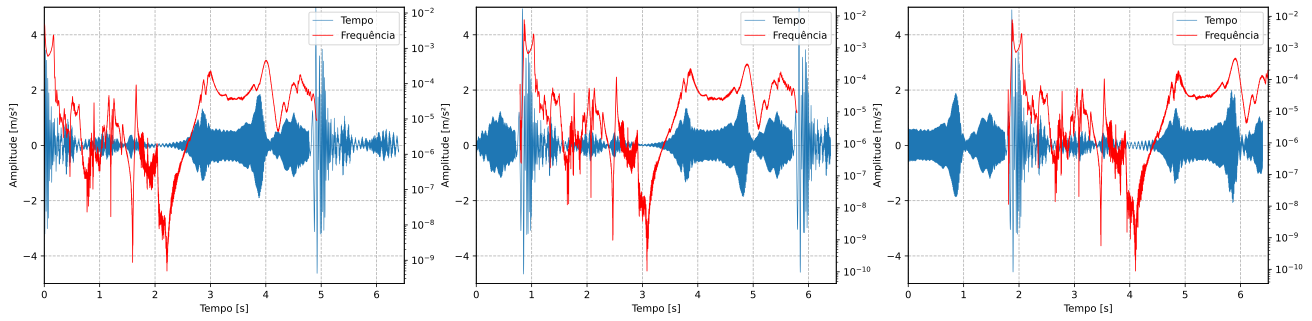

In [36]:
# 2GDL
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))


two_dgof_time = (
    experiment_data.filter((pl.col("type") == "2GDL") & (pl.col("domain") == "time"))
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

two_dgof_freq = (
    experiment_data.filter(
        (pl.col("type") == "2GDL") & (pl.col("domain") == "frequency")
    )
    .with_columns(
        pl.when(pl.col("run") == 1)
        .then(pl.lit(-0.08))
        .when(pl.col("run") == 2)
        .then(0.79)
        .otherwise(1.8)
        .alias("offset")
    )
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run", "offset")
)

for idx, ax in enumerate(axs.flat):
    ax2 = ax.twinx()
    current_run_time = two_dgof_time.filter(pl.col("run") == (idx + 1))
    current_run_freq = two_dgof_freq.filter(pl.col("run") == (idx + 1))
    ax.plot(
        current_run_time.select("x"),
        current_run_time.select("amplitude"),
        linewidth=0.6,
        label="Tempo",
    )
    ax2.semilogy(
        (current_run_freq.select("x") / 200) + current_run_freq.select("offset"),
        current_run_freq.select("amplitude"),
        linewidth=0.8,
        color="r",
        label="Frequência",
    )
    ax.set_xlim((0, 6.5))
    ax.set_ylim((-5, 5))
    ax.set_xlabel("Tempo [s]")
    ax.set_ylabel("Amplitude [m/s²]")
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="best")
    ax.grid(axis="both", linestyle="--")

plt.savefig("experimento4/time_freq_2gdl.eps", format="eps", bbox_inches="tight")
plt.show()

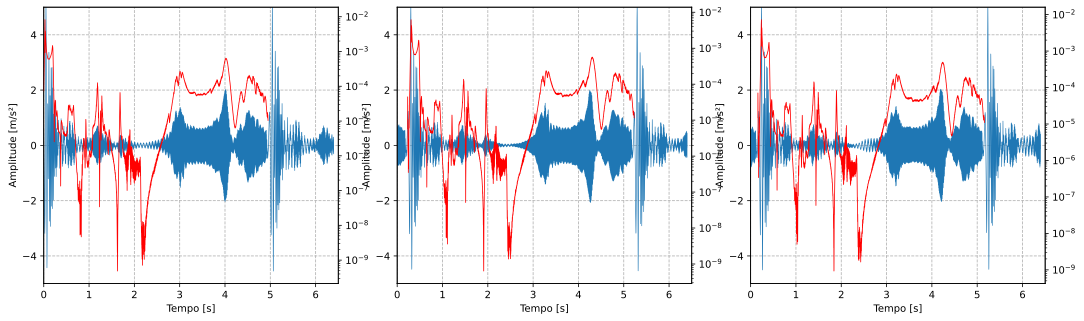

In [98]:
# 3GDL
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


three_dgof_time = (
    experiment_data.filter((pl.col("type") == "3GDL") & (pl.col("domain") == "time"))
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

three_dgof_freq = (
    experiment_data.filter(
        (pl.col("type") == "3GDL") & (pl.col("domain") == "frequency")
    )
    .with_columns(
        pl.when(pl.col("run") == 1)
        .then(pl.lit(-0.05))
        .when(pl.col("run") == 2)
        .then(0.23)
        .otherwise(0.16)
        .alias("offset")
    )
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run", "offset")
)

for idx, ax in enumerate(axs.flat):
    ax2 = ax.twinx()
    current_run_time = three_dgof_time.filter(pl.col("run") == (idx + 1))
    current_run_freq = three_dgof_freq.filter(pl.col("run") == (idx + 1))
    ax.plot(
        current_run_time.select("x"),
        current_run_time.select("amplitude"),
        linewidth=0.6,
    )
    ax2.semilogy(
        (current_run_freq.select("x") / 200) + current_run_freq.select("offset"),
        current_run_freq.select("amplitude"),
        linewidth=0.8,
        color="r",
    )
    ax.set_xlim((0, 6.5))
    ax.set_ylim((-5, 5))
    ax.set_xlabel("Tempo [s]")
    ax.set_ylabel("Amplitude [m/s²]")
    ax.grid(axis="both", linestyle="--")

plt.savefig("experimento4/time_freq_3gdl.eps", format="eps", bbox_inches="tight")
plt.show()

In [99]:
fig = px.scatter(
    three_dgof_freq.filter(pl.col("run") == 2), x="x", y="amplitude", log_y=False
)
fig.show()